## Kaggle Toxic comment 

### Project description
Apply Fastai lesson 10 to Kaggle toxic comment challenge. 
The competition has 6 classes, but first will make it binary, i.e. toxic & not toxic.

The overall strategy is to first train a language model. Fortunately, Jeremy H has done the hard work of training a language model on wikipedia (WikiText103). Using the pretrained language model as the backbone, we'll train a classifier to categorize the comments. 

### Load Libraries

In [1]:
from fastai.text import *
import html
import pdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Path  Directories

In [2]:
PATH = Path('/home/odenigborig/Data/kaggle/toxic_comment')

In [3]:
#path to store fine-tuned language model weights. 
LM_PATH = PATH/'LM'
LM_PATH.mkdir(exist_ok=True)

In [4]:
#path to store weights of classifier.
CLASSIFIER_PATH = PATH/'classifier'
CLASSIFIER_PATH.mkdir(exist_ok=True)

### Data Inspection

In [5]:
df = pd.read_csv(PATH/'train.csv')
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [6]:
print('Training set size: {} comments'.format(len(df)))

Training set size: 159571 comments


In [7]:
df[df['toxic'] == 1].tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0
159554,ffbdbb0483ed0841,and i'm going to keep posting the stuff u dele...,1,0,1,0,1,0


In [6]:
CLASSES = list(df.columns.values)[2:]
CLASSES

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Create additional column for binary class.

In [7]:
df['not_toxic'] = df[CLASSES].eq(0).all(1).astype('int')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [10]:
print('# non-toxic comments: {}'.format(sum(df['not_toxic'])))
print('# toxic comments: {}'.format(abs(len(df) - sum(df['not_toxic']))))
print('% not toxic: {:0.2f}%'.format(100*sum(df['not_toxic'])/len(df)))

# non-toxic comments: 143346
# toxic comments: 16225
% not toxic: 89.83%


Notice, there are a lot more non-toxic comments

In [11]:
df['not_toxic'].unique()

array([1, 0])

In [12]:
df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
not_toxic         int64
dtype: object

In [9]:
all_labels = df.drop(['comment_text','not_toxic'],axis=1)
y = all_labels[CLASSES].values
all_labels.head()

(                 id  toxic  severe_toxic  obscene  threat  insult  \
 0  0000997932d777bf      0             0        0       0       0   
 1  000103f0d9cfb60f      0             0        0       0       0   
 2  000113f07ec002fd      0             0        0       0       0   
 3  0001b41b1c6bb37e      0             0        0       0       0   
 4  0001d958c54c6e35      0             0        0       0       0   
 
    identity_hate  
 0              0  
 1              0  
 2              0  
 3              0  
 4              0  , (159571, 6))

In [15]:
np.save(PATH/'tmp'/'multi_labels.npy',y)

In [31]:
df_data = df[CLASSES+['comment_text']]
df_data.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0,0,0,0,0,0,Explanation\nWhy the edits made under my usern...
1,0,0,0,0,0,0,D'aww! He matches this background colour I'm s...
2,0,0,0,0,0,0,"Hey man, I'm really not trying to edit war. It..."
3,0,0,0,0,0,0,"""\nMore\nI can't make any real suggestions on ..."
4,0,0,0,0,0,0,"You, sir, are my hero. Any chance you remember..."


In [32]:
df_data.to_csv(PATH/'tmp'/'df_data_multilabel.csv',index=False)

fixup is a utility function from fastai for cleaning up text data. 

In [73]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


In [74]:
BOS = 'xbos'  #add beginning of sentence tag
FLD = 'xfld'  #add data field tag

def get_texts_tokens(df,n_labels=1):
    labels = df.iloc[:,range(n_labels)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df['comment_text'].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    #create tokens, using multi-processing
    tokens = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tokens,list(labels)

In [75]:
def get_all(df,n_labels):
    tokens,labels = [],[]
    tokens_,labels_ = get_texts_tokens(df,n_labels)
    tokens += tokens_
    labels += labels_
    return tokens,labels

## Text Classification on toxic comments

### Prepare data

In [33]:
df_data = pd.read_csv(PATH/'tmp'/'df_data_multilabel.csv')

df_train_class,df_rest_class = train_test_split(df_data,test_size=0.2)
df_valid_class,df_test_class = train_test_split(df_data,test_size=0.075)

In [34]:
display(df_train_class.head()),display(df_valid_class.head())

,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
12562,0,0,0,0,0,0,"Thanks, Anne and Roger. I would do all that yo..."
122292,0,0,0,0,0,0,(talk) Is not Little Brown his publisher if th...
17379,0,0,0,0,0,0,I've created a disambiguation page at Winter S...
20550,0,0,0,0,0,0,No problem at all - at least that site had the...
35000,0,0,0,0,0,0,"Thanks, Jusdafax\n For your advice I will crea..."


,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
74631,0,0,0,0,0,0,Edit request on 3 March 2014
112918,0,0,0,0,0,0,. The distinctive example is
94680,0,0,0,0,0,0,Another typical Ryulong thread. It's getting s...
126076,0,0,0,0,0,0,Because you clearly read that.
24694,0,0,1,0,0,0,"thanks a lot man, you dont know how long thats..."


(None, None)

In [35]:
len(df_train_class),len(df_valid_class),len(df_test_class)

(127656, 147603, 11968)

In [67]:
train_tokens,train_labels = get_all(df_train_class,len(CLASSES))
valid_tokens,valid_labels = get_all(df_valid_class,len(CLASSES))
test_tokens,test_labels = get_all(df_test_class,len(CLASSES))

In [71]:
valid_labels[10],valid_tokens[10]

(array([0, 0, 0, 0, 0, 0]),
 ['\n',
  'xbos',
  'xfld',
  '1',
  'geocities',
  '\n',
  'exactly',
  'what',
  'policy',
  'does',
  'a',
  'site',
  'published',
  'by',
  'geocities',
  'violate',
  '?',
  'the',
  'article',
  'is',
  'well',
  'and',
  'professionally',
  'written',
  'as',
  'well',
  'as',
  'nicely',
  '-',
  'presented',
  '.',
  'what',
  "'s",
  'unreliable',
  'about',
  'it',
  '?',
  'the',
  'fact',
  'that',
  'it',
  'was',
  'published',
  'on',
  'geocities',
  '?',
  'plenty',
  'of',
  'good',
  'articles',
  'are',
  'published',
  'on',
  'tripod.com',
  'or',
  'hispavista.es',
  'and',
  'they',
  "'re",
  'acceptable',
  '?',
  'why',
  ',',
  'because',
  'the',
  'user',
  'can',
  'invest',
  'on',
  'a',
  'domain',
  'name',
  '?',
  'because',
  'that',
  "'s",
  'the',
  'only',
  'difference',
  '.'])

In [72]:
#save tokens and labels
(CLASSIFIER_PATH/'tmp').mkdir(exist_ok=True)
np.save(CLASSIFIER_PATH/'tmp'/'train_tokens2.npy',train_tokens)
np.save(CLASSIFIER_PATH/'tmp'/'valid_tokens2.npy',valid_tokens)
np.save(CLASSIFIER_PATH/'tmp'/'test_tokens2.npy',test_tokens)

np.save(CLASSIFIER_PATH/'tmp'/'train_multilabels.npy',train_labels)
np.save(CLASSIFIER_PATH/'tmp'/'valid_multilabels.npy',valid_labels)
np.save(CLASSIFIER_PATH/'tmp'/'test_multilabels.npy',test_labels)

In [6]:
train_tokens = np.load(CLASSIFIER_PATH/'tmp'/'train_tokens2.npy')
valid_tokens = np.load(CLASSIFIER_PATH/'tmp'/'valid_tokens2.npy')
test_tokens = np.load(CLASSIFIER_PATH/'tmp'/'test_tokens2.npy')

Map the token ids used in the language model to the tokens created from the toxic comments data

In [7]:
int_to_str = pickle.load((LM_PATH/'tmp'/'int_to_str.pkl').open('rb'))
str_to_int = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})

train_class_inds = np.array([[str_to_int[o] for o in p] for p in train_tokens])
valid_class_inds = np.array([[str_to_int[o] for o in p] for p in valid_tokens])
test_class_inds = np.array([[str_to_int[o] for o in p] for p in test_tokens])

In [8]:
#save data
np.save(CLASSIFIER_PATH/'tmp'/'train_ids2.npy',train_class_inds)
np.save(CLASSIFIER_PATH/'tmp'/'valid_ids2.npy',valid_class_inds)
np.save(CLASSIFIER_PATH/'tmp'/'test_ids2.npy',test_class_inds)

### Create model dataloader. 

First we will need to pad the sequences to the same length in each batch. To create batches of the same size, we use the SortishSampler. The SortishSampler cuts down the overall number of padding tokens fed into the classifier.

In [5]:
train_class_inds = np.load(CLASSIFIER_PATH/'tmp'/'train_ids2.npy')
valid_class_inds = np.load(CLASSIFIER_PATH/'tmp'/'valid_ids2.npy')
test_class_inds = np.load(CLASSIFIER_PATH/'tmp'/'test_ids2.npy')

train_labels = np.load(CLASSIFIER_PATH/'tmp'/'train_multilabels.npy')
valid_labels = np.load(CLASSIFIER_PATH/'tmp'/'valid_multilabels.npy')
test_labels = np.load(CLASSIFIER_PATH/'tmp'/'test_multilabels.npy')

int_to_str = pickle.load((LM_PATH/'tmp'/'int_to_str.pkl').open('rb'))
str_to_int = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})

In [7]:
bs = 8           #batch size

train_dataset = TextDataset(train_class_inds,train_labels.astype('float32')) 
valid_dataset = TextDataset(valid_class_inds,valid_labels.astype('float32'))
test_dataset = TextDataset(test_class_inds,test_labels.astype('float32'))

train_sampler = SortishSampler(train_class_inds,key=lambda x: len(train_class_inds),bs=bs//2)
valid_sampler = SortSampler(valid_class_inds,key=lambda x: len(valid_class_inds[x]))
test_sampler = SortSampler(test_class_inds,key=lambda x: len(test_class_inds[x]))

train_dataloader = DataLoader(train_dataset,bs//2,transpose=True,num_workers=1,pad_idx=1,sampler=train_sampler)
valid_dataloader = DataLoader(valid_dataset,bs,transpose=True,num_workers=1,pad_idx=1,sampler=valid_sampler)
test_dataloader = DataLoader(test_dataset,bs,transpose=True,num_workers=1,pad_idx=1,sampler=test_sampler)

TextData = ModelData(PATH,train_dataloader,valid_dataloader,test_dataloader)

In [10]:
x,y =TextData.trn_ds[0]

In [15]:
V(x)

Variable containing:
   12
   16
   17
   15
  122
    4
 6071
   10
 4828
    2
    8
   64
   39
   63
   18
   13
  145
   38
[torch.cuda.LongTensor of size 18 (GPU 0)]

In [ ]:
l = valid_labels.float()
type(l)

In [10]:
train_dataset.x[1],train_dataset.y[1]

([12,
  16,
  17,
  15,
  31,
  75,
  28,
  14,
  25,
  265,
  1717,
  93,
  2760,
  44,
  66,
  1016,
  19,
  62,
  8,
  57,
  108,
  19,
  2,
  8,
  35,
  4861,
  18,
  13,
  57,
  3522,
  9],
 array([0., 0., 0., 0., 0., 0.], dtype=float32))

### Create RNN Classifier
As mentioned above, our classifier consists of 3 LSTM (AWD-LSTM) layers followed by 2 linear layers (including the classification layer).

In [43]:
def train_rnn_classifier():
    embed_dim = 400   #embedding dimensions to encode each token
    n_units = 1150    #number of hidden activation units per LSTM layer
    n_layers = 3      #number of LSTM layers
    vocab_size = len(int_to_str) #number of tokens/vocabulary size
    bptt = 70         #batch size for back prop thru time  
    dropouts = np.array([0.4,0.5,0.05,0.3,0.4])*0.5 #dropout for each layer of the model
    #lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
    lr=3e-3
    lrm = 2.6
    lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
    weight_decay=1e-7
    n_cats = 6 #number of categories or classes
    
    m = get_rnn_classifer(bptt,max_seq=20*70,n_class=n_cats,n_tok=vocab_size,emb_sz=embed_dim,n_hid=n_units,
                          n_layers=n_layers,pad_token=1,layers=[embed_dim*3,40,n_cats],drops=[dropouts[4],0.1],
                          dropouti=dropouts[0],wdrop=dropouts[1],dropoute=dropouts[2],dropouth=dropouts[3])
        
    learn = RNN_Learner(TextData, TextModel(to_gpu(m)),opt_fn=partial(optim.Adam, betas=(0.8,0.99)))
    learn.reg_fn = partial(seq2seq_reg,alpha=2.,beta=1.) #regularization function
    learn.clip = 25.   #gradient clipping
    learn.metrics = [accuracy_thresh(0.5)] #multilabel accuracy
    learn.crit = F.binary_cross_entropy_with_logits
    print(learn.summary)
    
    #fine tune last layer
    print('Finetuning last layer...')
    learn.freeze_to(-1)
    learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))
    learn.save('classifier_multi_0') 
    
    # load pretrained language model & fine tune last layer
    print('Load pretrained LM & finetuning last layer...')
    learn.load_encoder('LM1_encoder')
    learn.freeze_to(-1)
    learn.fit(lrs,1,wds=weight_decay,cycle_len=1,use_clr=(8,3))
    learn.save('classifier_multi_1') 
    
    #train last two layers
    print('Finetuning last two layers...')
    learn.freeze_to(-2)
    learn.fit(lrs,1,wds=weight_decay,cycle_len=1, use_clr=(8,3))
    learn.save('classifier_multi_2')

    #unfreeze all layers
    print('Finetuning all layers...')
    learn.unfreeze()
    learn.fit(lrs,1,wds=weight_decay,cycle_len=2,use_clr=(32,10))
    learn.save('classifier_multi_3') 

    learn.sched.plot_lr()
    learn.sched.plot_loss()
    
    return learn

<bound method Learner.summary of SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=40, bias=True)
        (drop): Dropout(p=0.2)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=40, out_features=6, bias=True)
        (drop): Dropou

epoch      trn_loss   val_loss   <lambda>                         
    0      0.135037   0.128958   0.968302  
Load pretrained LM & finetuning last layer...


epoch      trn_loss   val_loss   <lambda>                         
    0      0.100556   0.08238    0.976632  
Finetuning last two layers...


 86%|████████▌ | 27515/31914 [43:14<06:54, 10.61it/s, loss=0.0493]epoch      trn_loss   val_loss   <lambda>   
    0      0.050588   0.075263   0.977845  
Finetuning all layers...


    2      0.053839   4.404462   0.981287                           
    3      0.046239   0.085257   0.981689                           


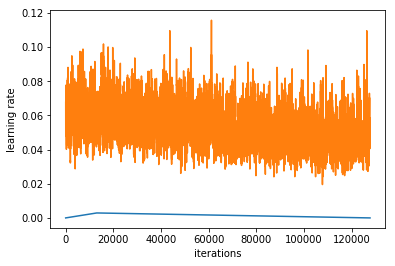

In [44]:
learner = train_rnn_classifier()

In [96]:
embed_dim = 400   #embedding dimensions to encode each token
n_units = 1150    #number of hidden activation units per LSTM layer
n_layers = 3      #number of LSTM layers
vocab_size = len(int_to_str) #number of tokens/vocabulary size
bptt = 70         #batch size for back prop thru time  
dropouts = np.array([0.4,0.5,0.05,0.3,0.4])*0.5 #dropout for each layer of the model
#lrs = np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
weight_decay=1e-7
n_cats = 6 #number of categories or classes

m = get_rnn_classifer(bptt,max_seq=20*70,n_class=n_cats,n_tok=vocab_size,emb_sz=embed_dim,n_hid=n_units,
                      n_layers=n_layers,pad_token=1,layers=[embed_dim*3,40,n_cats],drops=[dropouts[4],0.1],
                      dropouti=dropouts[0],wdrop=dropouts[1],dropoute=dropouts[2],dropouth=dropouts[3])

learn = RNN_Learner(TextData, TextModel(to_gpu(m)),opt_fn=partial(optim.Adam, betas=(0.8,0.99)))
learn.reg_fn = partial(seq2seq_reg,alpha=2.,beta=1.) #regularization function
learn.clip = 25.   #gradient clipping
learn.metrics = [accuracy_thresh(0.5)] #multilabel accuracy
learn.crit = F.binary_cross_entropy_with_logits

In [ ]:
learn.lr_find(start_lr=lrs/100,end_lr=lrs*10,linear=True)

 84%|████████▎ | 26699/31914 [1:18:02<15:14,  5.70it/s, loss=0.693]

In [28]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.lr_find(lrs/1000)

epoch      trn_loss   val_loss   <lambda>                          
    0      0.693147   0.693147   0.968302  



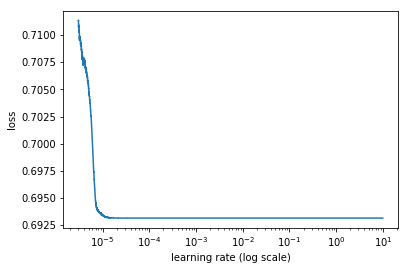

In [29]:
learn.sched.plot()

 31%|███▏      | 10000/31914 [39:48<1:27:13,  4.19it/s, loss=0.15] 

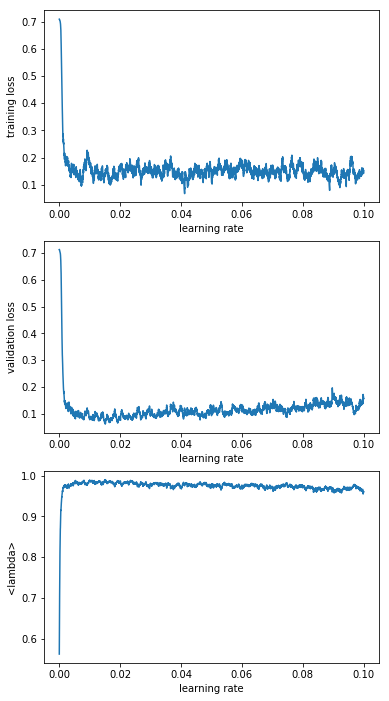

In [36]:
learn.lr_find2(start_lr=lrs/1000,end_lr=lrs*10,num_it=10000,linear=True)
learn.sched.plot()

  8%|▊         | 2500/31914 [13:34<2:39:37,  3.07it/s, loss=0.174] 

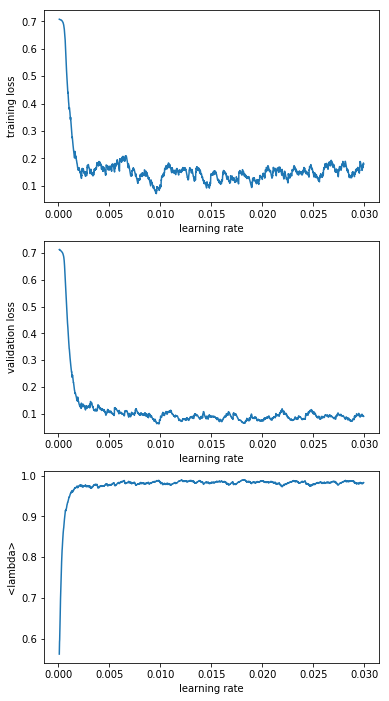

In [38]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.lr_find2(start_lr=lrs/1000,end_lr=lrs*10,num_it=2500,linear=True)
learn.sched.plot()

In [ ]:
%debug

### Notes
for multilabel problem have to:
- use `binary_crossentropy`, not crossentropy(which can only deal with single-label multiclass).
- add `Sigmoid()` at the end to make sure that the output is squashed between 0 and 1
    - use `F.binary_cross_entropy_with_logits` which adds sigmoid and according to the docs is more numerically stable than `Sigmoid()` followed by `F.binary_crossentropy`

### Predict on kaggle dataset

In [88]:
df_kag_test = pd.read_csv(PATH/'test.csv',index_col='id')
df_kag_test['label']=0
df_kag_test = df_kag_test.reindex(columns=['label','comment_text'])
display(df_kag_test.sample(4))


,label,comment_text
id,,
ed47043e3831edf5,0,You all are pathetic! Don't you have any lives...
407670984af4bc1d,0,The article Teddy Margules has been speedily d...
556f03c9ce26e430,0,Please stop. If you continue to blank out or d...
544318b0b1651d68,0,""":::::::He's entitled to use whatever language..."


In [93]:
kag_tokens, kag_test_y = get_all(df_kag_test,1)
np.save(CLASSIFIER_PATH/'tmp'/'kag_test_tokens.npy',kag_tokens)

kag_class_ids = np.array([[str_to_int[o] for o in p] for p in kag_tokens])
kag_dataset = TextDataset(kag_test_class_ids,kag_test_y)
kag_sampler = SortSampler(kag_test_class_ids,key=lambda x: len(kag_class_ids[x]))
kag_dataloader = DataLoader(kag_dataset,bs,transpose=True,num_workers=1,pad_idx=1,sampler=kag_sampler)

In [95]:
TextData = ModelData(PATH,train_dataloader,valid_dataloader,kag_dataloader)

In [127]:
learner.load('classifier_multi_1')

In [64]:
def get_model_output(learner,is_test=True):
    model_pred = learner.predict(is_test) 
    sigmoid = nn.Sigmoid()
    output = sigmoid(torch.from_numpy(model_pred))
    
    return output

In [ ]:
learner.data.test_ds[0],kag_dataset[0]

((array([   12,    16,    17,    15,  1960,   476,  5190,   728,    14,    82, 21314,   109,    13,   189,
           373,    30,    61,   461,    98,    42,    13,    10,  6247,    13,  1564,     0,    96,     8,
            78,   476,  5034,  1459,     0,   576,  5582,    10,   121,    13,     6,  3609,    53,   397,
            13,   774, 37396,    62,     2,  5190,   728,    14,    59,  4175,    20,  1226,   667,   402,
             2,    39,   264, 18053,    18,   286,    27,   186,     2,    10, 20936,    14,   277, 20909,
            72,  3949,    69,    46,    11,  1954,   185,    96,  1935,   576,  2343,   121,   251,   174,
           510,   112,     2,     4]), array([0])),
 (array([   12,    16,    17,    15,  1960,   476,  5190,   728,    14,    82, 21314,   109,    13,   189,
           373,    30,    61,   461,    98,    42,    13,    10,  6247,    13,  1564,     0,    96,     8,
            78,   476,  5034,  1459,     0,   576,  5582,    10,   121,    13,     6,  3609,

In [106]:
kag_preds = get_model_output(learner)
kag_preds = np.array(kag_preds)
kag_preds[1]

array([0.95828, 0.96585, 0.96613, 0.35649, 0.94199, 0.62327], dtype=float32)

In [110]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [115]:
sample_submission = pd.read_csv(PATH/'sample_submission.csv')
sample_submission[sample_submission.columns[1:]] = kag_preds
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0000247867823ef7,0.958278,0.965848,0.966133,0.356485,0.941992,0.623268
2,00013b17ad220c46,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,00017563c3f7919a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,00017695ad8997eb,0.183055,0.049177,0.112638,0.010058,0.072082,0.052659


In [131]:
from IPython.display import FileLink

fname = 'submission_ft_1.csv'
sample_submission.to_csv(fname, index=False)
FileLink(fname)

/home/odenigborig/Github/Kaggle/toxic_comment/submission_ft_1.csv

the above submission led to a score of 0.4963 on the leaderboard, which is pretty pathetic.

In [108]:
df_kag_test.head()

,label,comment_text
id,,
00001cee341fdb12,0,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,0,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,0,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,0,":If you have a look back at the source, the in..."
00017695ad8997eb,0,I don't anonymously edit articles at all.


In [120]:
df_kag_test.comment_text[2]

'" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "'

In [129]:
from sklearn.metrics import roc_auc_score
learner.load('classifier_multi_2')
valid_preds = get_model_output(learner,is_test=False)
print(valid_labels.shape,valid_preds.shape)

roc_auc_score(valid_labels, valid_preds, average='micro')

0.6043962100104063

In [130]:
learner.load('classifier_multi_3')
valid_preds = get_model_output(learner,is_test=False)
roc_auc_score(valid_labels, valid_preds, average='macro')

0.5033316901382017

In [133]:
learner.load('classifier_multi_3')
kag_preds = get_model_output(learner,is_test=True)

sample_submission = pd.read_csv(PATH/'sample_submission.csv')
sample_submission[sample_submission.columns[1:]] = kag_preds
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.035039,0.001655,0.012902,0.000298,0.007412,0.001622
1,0000247867823ef7,0.844906,0.826290,0.990221,0.034233,0.714253,0.011708
2,00013b17ad220c46,0.007828,0.000705,0.003755,0.000227,0.001690,0.000668
3,00017563c3f7919a,0.820688,0.440795,0.613387,0.620212,0.665691,0.320917
4,00017695ad8997eb,0.965075,0.908097,0.984693,0.695256,0.928719,0.082633


In [134]:
fname = 'submission_ft_all.csv'
sample_submission.to_csv(fname, index=False)
FileLink(fname)

/home/odenigborig/Github/Kaggle/toxic_comment/submission_ft_all.csv

the sbove submission scored 0.522 on the leaderboard. much better than previous submission but certainly FAR from amazing. 

In [16]:
learn.summary

<bound method Learner.summary of SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.15)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.15)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.15)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=5, bias=True)
        (drop): Dropout(p=0.2)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=5, out_featu